In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np

from hydra import compose, initialize
import os

# 加载项目层面的配置
with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config")
os.chdir(cfg.root)


from matplotlib import pyplot as plt

%matplotlib inline

# Figure S1, 研究区

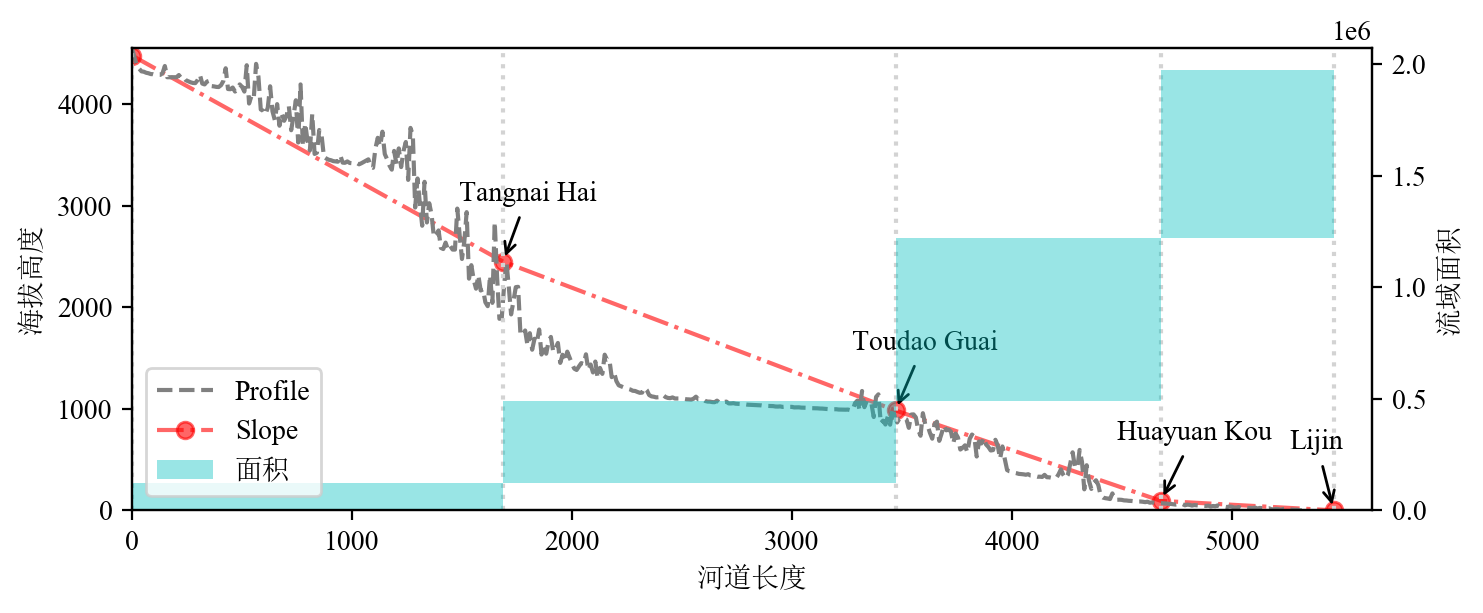

In [2]:
from mksci_font import config_font

config_font()

# 处理控制站点数据（来源于黄河流域综合规划）
features = pd.read_csv("data/hydrology/river_features.csv")
features.columns = [k.strip() for k in features.columns]
length = features["length"].cumsum().values.tolist()
length.insert(0, 0)
fall = (
    features["fall"]
    .sort_index(ascending=False)
    .cumsum()
    .sort_index(ascending=True)
    .values.tolist()
)
fall.insert(4, 0)

# 处理高程数据 （来源于Arcgis DEM数据）
from regimes_yrb.tools.processing import dbf_data_list, pd_read_dbf

altitude = pd_read_dbf(
    "data/hydrology/altitude_points_along_yr/altitude_points.dbf",
    use_cols=["Shape_Leng", "RASTERVALU"],
)
altitude["Shape_Leng"] /= 1000  # 单位将 米 转化为 千米
# altitude['RASTERVALU'] /= 1000  # 高程单位转化为千米
# 485号点开始，有几个数据是错误的位置，给他们标好顺序
reindex = list(np.arange(len(altitude) - 485, len(altitude))) + list(
    np.arange(len(altitude) - 485)
)
altitude.index = reindex
altitude.sort_index(inplace=True)
# 将河流全长，按照点的数量进行划分
altitude["Shape_Leng"] = np.linspace(0, altitude["Shape_Leng"].iloc[0], len(altitude))

# 处理流域集水面积数据
stations = pd.read_csv("data/hydrology/hydro_stations.csv")

# 作图
fig, ax = plt.subplots(figsize=(8, 3))

slope = ax.plot(length, fall, "-.o", color="red", alpha=0.6, label="Slope")
profile = ax.plot(
    altitude["Shape_Leng"],
    altitude["RASTERVALU"],
    "--",
    color="gray",
    label="Profile",
)
for i, x in enumerate(length):
    ax.axvline(x, ls=":", color="lightgray")

# 绘制图 2 每个站点的流域控制面积
ax2 = ax.twinx()
bottom = 0
for i in range(4):
    height = stations["catchment area"][i]
    width = length[i + 1] - length[i]
    center = length[i] + width / 2
    area = ax2.bar(
        x=length[i],
        align="edge",
        width=width,
        bottom=bottom,
        height=height,
        color="c",
        alpha=0.4,
        label="面积",
    )
    bottom += height
    ax.annotate(
        stations["station"][i],
        xy=(length[i + 1], fall[i + 1]),
        xycoords="data",
        xytext=(length[i + 1] - 200, fall[i + 1] + 600),
        textcoords="data",
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
    )

ax.set_xlim(altitude["Shape_Leng"].min(), altitude["Shape_Leng"].max() * 1.06)
ax.set_ylim(altitude["RASTERVALU"].min(), altitude["RASTERVALU"].max())
ax.set_xlabel("河道长度")
ax.set_ylabel("海拔高度")
ax2.set_ylabel("流域面积")
plt.legend(handles=profile + slope + [area], loc="lower left")
# 添加指示线，控制站名称

plt.savefig("figures/sup/slope.jpg", dpi=300)
plt.savefig("figures/sup/slope.pdf", dpi=300)
plt.show();

# Figure S2, 子区域的对比

## 区域差异合并作图

/Users/songshgeo/Documents/VSCode/WGRegimes_YRB_2020/regimes_yrb/tools/region_differences.py:153: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(legends, labels=INDUSTRIES_eng)
/Users/songshgeo/Documents/VSCode/WGRegimes_YRB_2020/regimes_yrb/tools/region_differences.py:286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[sector + "_sum"] = data[sur] + data[gro]
/Users/songshgeo/Documents/VSCode/WGRegimes_YRB_2020/regimes_yrb/tools/region_differences.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

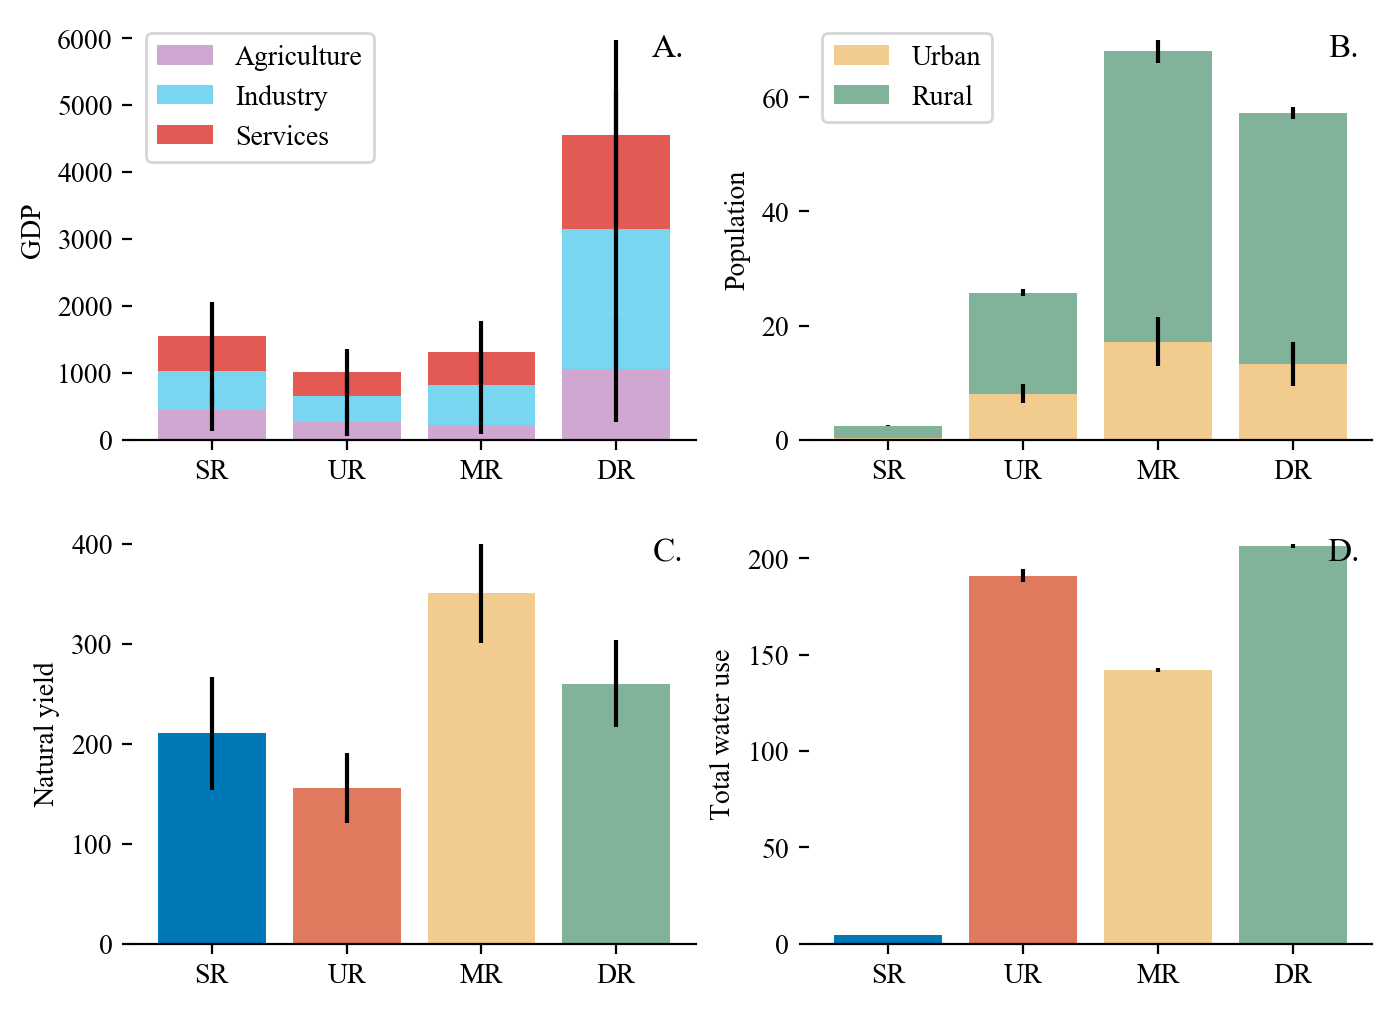

In [3]:
from regimes_yrb.tools.region_differences import plot_gdp, plot_pop, plot_water, plot_wu
from regimes_yrb.tools.values import index_colors, region_colors
from regimes_yrb.tools.processing import get_position_by_ratio

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))

start_yr, end_yr = 1980, 2000
plot_gdp(ax1, index_colors, 1980, 2000)
plot_pop(ax2, region_colors[-2:], start_yr, end_yr)
plot_water(ax3, start_yr, end_yr, region_colors)
plot_wu(ax4, region_colors, start_yr, end_yr)

# 修饰图片

labels = ["A.", "B.", "C.", "D."]
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    x, y = get_position_by_ratio(ax, 0.95, 0.93)
    ax.text(x, y, labels[i], ha="center", va="center", weight="bold", size="large")

    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(True)

    ax.set_xlabel("")

plt.savefig("figures/sup/region_differences.jpg", dpi=300)
plt.savefig("figures/sup/region_differences.pdf", dpi=300)
plt.show();

In [4]:
from regimes_yrb.tools.region_differences import get_consumptions_ratio

get_consumptions_ratio(1972)

0.7765110845359886

# Fig. S3 径流

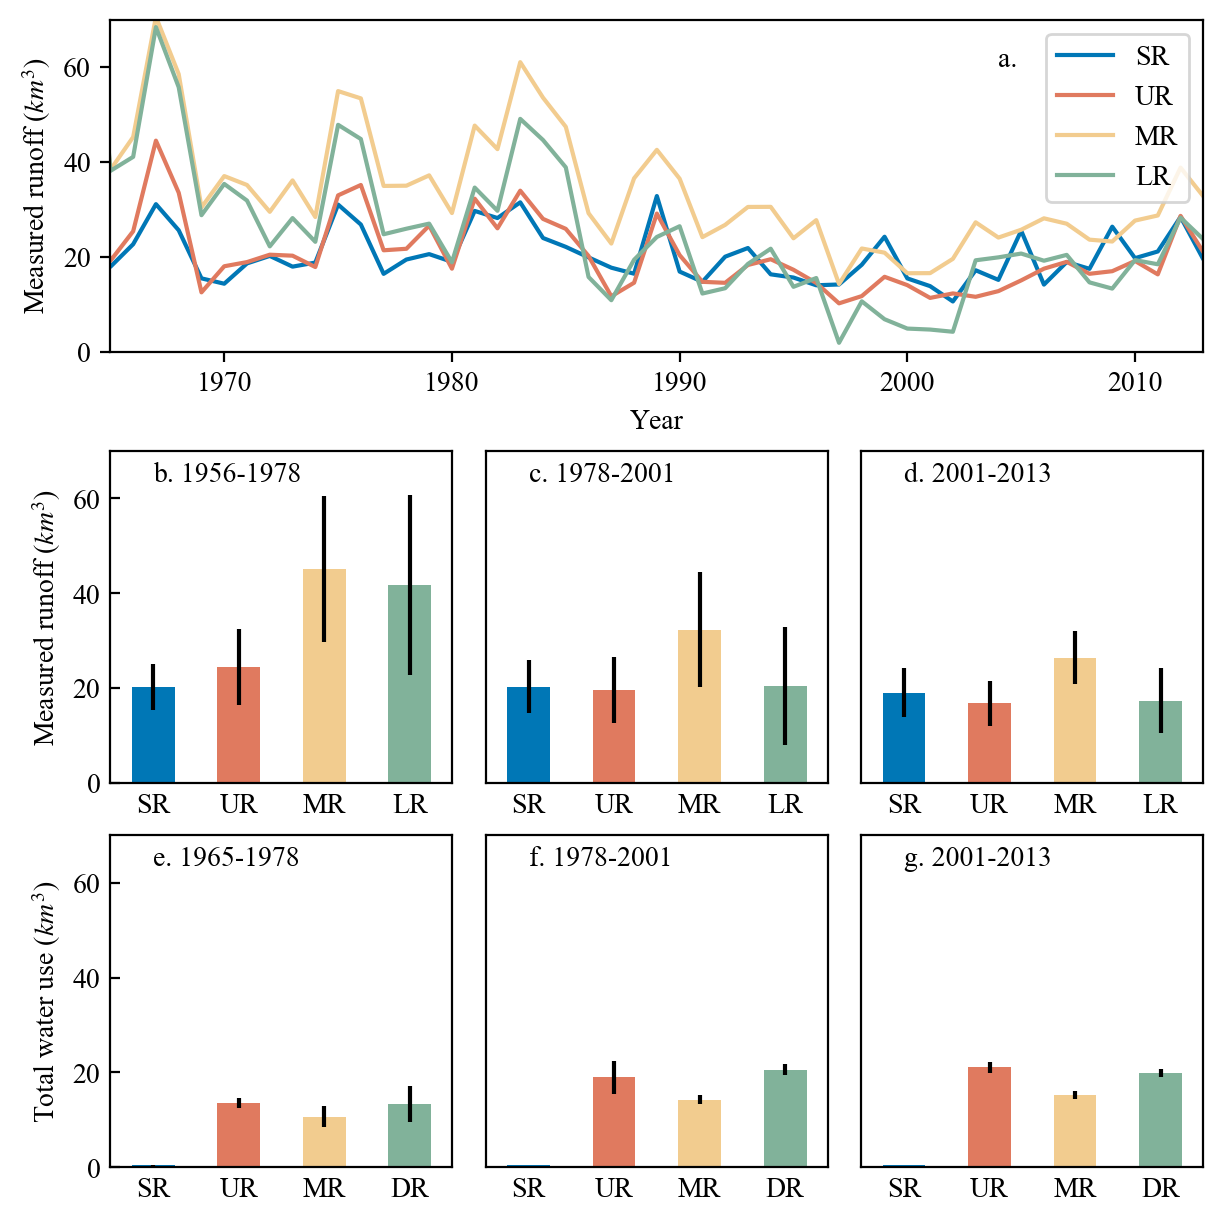

In [15]:
from matplotlib.gridspec import GridSpec
from regimes_yrb.tools.values import region_colors, REGIONS

# 加载径流和水库数据
# use_cols = {
#     "唐乃亥": "源区",  # 唐乃亥控制源区
#     "头道拐": "上游",  # 头道拐控制上游
#     "花园口": "中游",  # 花园口控制中游
#     "利津": "下游",  # 利津控制下游
# }
use_cols = {
    "唐乃亥": "SR",  # 唐乃亥控制源区
    "头道拐": "UR",  # 头道拐控制上游
    "花园口": "MR",  # 花园口控制中游
    "利津": "LR",  # 利津控制下游
}
measured_runoff = pd.read_csv(r"data/hydrology/1956-2016_runoff.csv", index_col="年份")
measured_runoff = measured_runoff.loc[:, use_cols.keys()]
measured_runoff.rename(use_cols, axis=1, inplace=True)

fig = plt.figure(figsize=(6, 6), constrained_layout=True)
gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])
ax3 = fig.add_subplot(gs[1, 2])
ax4 = fig.add_subplot(gs[0, :])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
ax7 = fig.add_subplot(gs[2, 2])
axs = [ax1, ax2, ax3]

endpoints = [*cfg.breakpoints, 2013]
markers = ["b.", "c.", "d."]
startpoint = measured_runoff.index.min()
for i, endpoint in enumerate(endpoints):
    ax = axs[i]
    use_data = measured_runoff.loc[startpoint:endpoint, :] / 10
    use_data.mean().plot.bar(yerr=use_data.std(), ax=ax, color=region_colors)

    ax.set_ylim(0, 70)
    ax.text(
        0.0,
        65,
        "{} {}-{}".format(markers[i], startpoint, endpoint),
        ha="left",
        va="center",
        weight="bold",
    )
    startpoint = endpoint
    ax.axes.get_yaxis().set_visible(False)
    ax.tick_params(axis="x", tickdir="in", bottom=False, labelrotation=0)
    ax.tick_params(axis="y", tickdir="in", bottom=False, labelrotation=0)
    ax.set_ylim(ax1.get_ylim())

# axs[0].set_ylabel("实测径流量")
axs[0].set_ylabel("Measured runoff")
axs[0].axes.get_yaxis().set_visible(True)

(measured_runoff / 10).plot(ax=ax4, color=region_colors)  # 径流线图
ax4.set_xlabel("Year")
# ax4.set_ylabel("实测径流量 ($km^3$)")
# ax1.set_ylabel("实测径流量 ($km^3$)")
ax4.set_ylabel("Measured runoff ($km^3$)")
ax1.set_ylabel("Measured runoff ($km^3$)")
ax4.set_xlim(1965, 2013)
ax4.set_ylim(0, 70)

## ============= 画总用水图
city_yr = pd.read_csv(
    "data/perfectures/yr/perfectures_in_YR_with_threshold_0.05.csv",
    index_col=0,
)
twu_regions = city_yr.groupby(["Region", "Year"])["Total water use"].sum()
twu_regions = pd.DataFrame({r: twu_regions.loc[r] for r in REGIONS})

axs = [ax5, ax6, ax7]
markers = ["e.", "f.", "g."]
startpoint = twu_regions.index.min()
for i, endpoint in enumerate(endpoints):
    ax = axs[i]
    use_data = twu_regions.loc[startpoint:endpoint, :]
    use_data.mean().plot.bar(yerr=use_data.std(), ax=ax, color=region_colors)
    ax.set_ylim(0, 27)
    ax.text(
        0.0,
        65,
        "{} {}-{}".format(markers[i], startpoint, endpoint),
        ha="left",
        va="center",
        weight="bold",
    )
    startpoint = endpoint
    ax.axes.get_yaxis().set_visible(False)
    ax.tick_params(axis="x", tickdir="in", bottom=False, labelrotation=0)
    ax.tick_params(axis="y", tickdir="in", bottom=False, labelrotation=0)
    ax.set_ylim(ax1.get_ylim())
    # ax.set_xticklabels(["源区", "上游", "中游", "下游"])

axs[0].set_ylabel("Total water use ($km^3$)")
# axs[0].set_ylabel("总用水量 ($km^3$)")
axs[0].axes.get_yaxis().set_visible(True)

ax4.text(2004, 60, "a.", weight="bold")

plt.savefig("figures/sup/sf_measured_runoff.pdf", dpi=300)
plt.savefig("figures/sup/sf_measured_runoff.jpg", dpi=300)
plt.show();

# Fig. S6 堆积图

In [ ]:
wu_cols = ["IND", "RUR", "URB", "IRR"]
wu_sections = city_yr.groupby(["Year"])[wu_cols].sum()

# 绘图
fig, ax1 = plt.subplots(1, 1, figsize=(4, 4))
ax1.stackplot(
    wu_sections.index,
    wu_sections.T,
    labels=wu_cols,
    colors=["#e07a5f", "#f2cc8f", "#81b29a", "#EDAE49"],
)
ax1.set_xlabel("Year")
ax1.set_ylabel("Total water use ($km^3$)")
ax1.set_xlim(wu_sections.index.min(), wu_sections.index.max())
ax1.set_yticks(np.arange(0, 61, 15))
ax1.set_ylim(0, 65)
ax1.yaxis.grid(color="white", linestyle="-.", linewidth=0.5)
ax1.axvline(x=1977, ls=":", lw=1.5, c="black")
ax1.axvline(x=1993, ls=":", lw=1.5, c="black")
ax1.legend(loc=2)

# percentages = plot_percentages(wu_sections, colors=["#e07a5f", "#f2cc8f","#81b29a", "#EDAE49"], ax=ax2)
plt.savefig("figures/sup/sf_wu_sections_stackplot.jpg", dpi=300)
plt.show();

# Fig. S7 节水措施

In [ ]:
from regimes_yrb.tools.processing import get_region_by_province_name

saving_water = pd.read_excel("data/saving_water.xlsx")
saving_water["Region"] = saving_water["Province"].apply(get_region_by_province_name)
saving_water.head()

In [ ]:
# 按区域进行加和
sw_region = saving_water.groupby("Region").sum()

# 计算每个区域的节水率
sw_region["Rate"] = sw_region.iloc[:, 2:].sum(axis=1) / sw_region["Irrigated area"]

fig, ax = plt.subplots()
new_sw_region_df = pd.DataFrame({region: sw_region.T[region] for region in REGIONS})
new_sw_region_df.loc["Rate"].plot.bar(ax=ax, color=region_colors)
ax.set_xlabel("Region")
ax.set_ylabel("Saving water irrigation rate")

for tick in ax.get_xticklabels():  # 旋转角度
    tick.set_rotation(0)  # 轴标签旋转

plt.savefig("figures/sup/saving_water.jpg", dpi=300)
plt.savefig("figures/sup/saving_water.pdf", dpi=300)
plt.show();

# Fig. S8 不同时期 GDP 贡献百分比

In [ ]:
from regimes_yrb.tools.values import INDUSTRIES, INDUSTRIES_eng
from regimes_yrb.tools.region_differences import extract_gdp_by_industry, get_yr_gdp_data

gdp = get_yr_gdp_data()
gdp_yr = pd.DataFrame()
for i, industry in enumerate(INDUSTRIES):
    gdp_yr[INDUSTRIES_eng[i]] = extract_gdp_by_industry(gdp, industry)

gdp_yr.head()

In [ ]:
# 制作三元图
from regimes_yrb.tools.values import period_colors

points = []
points_1, points_2, points_3 = [], [], []
size_1, size_2, size_3 = [], [], []
scale = 100

z_ipwu, z_wdi, z_sfv = [gdp_yr[col] for col in gdp_yr]
for yr in gdp_yr.index:
    sumed = z_ipwu[yr] + z_wdi[yr] + z_sfv[yr]  # 这里点的大小是三者 z_score 相加
    point = (z_ipwu[yr] / sumed, z_wdi[yr] / sumed, z_sfv[yr] / sumed)
    points.append(point)
    if yr == 1993:
        print(point)
    if yr < 1978:
        points_1.append(point)
        size_1.append(sumed * scale)
    elif yr < 1993:
        points_2.append(point)
        size_2.append(sumed * scale)
    else:
        points_3.append(point)
        size_3.append(sumed * scale)

import ternary

fig, ax = plt.subplots(figsize=(4, 4))
figure, tax = ternary.figure(ax=ax, scale=1)
tax.boundary()
tax.gridlines(ls="-.", multiple=1.0 / 3, color="gray")
# Plot a few different styles with a legend
tax.scatter(points_1, marker="o", color=period_colors[0], label="P1", alpha=0.4)
tax.scatter(points_2, marker="o", color=period_colors[1], label="P2", alpha=0.4)
tax.scatter(points_3, marker="o", color=period_colors[2], label="P3", alpha=0.4)
tax.plot(points, ls=":", lw="0.7")
fontsize = 12
offset = 0.15

tax.ticks(axis="brl", multiple=1.0 / 3, linewidth=1, tick_formats="%.1f", offset=0.03)
# tax.ticks(axis='l', clockwise=True, multiple=1./3, linewidth=1, tick_formats="%.1f", offset=0.03)
tax.get_axes().axis("off")
tax.clear_matplotlib_ticks()


def get_point(yr):
    a = z_ipwu[yr] + z_wdi[yr] - z_sfv[yr]
    return (z_ipwu[yr] / a, z_wdi[yr] / a, z_sfv[yr] / a)


tax.set_axis_limits((0, 1))
tax.line((0, 0, 1), (0.5, 0.5, 0), ls=":", color="red")
tax.line((0, 1, 0), (0.5, 0, 0.5), ls=":", color="red")
tax.line((1, 0, 0), (0, 0.5, 0.5), ls=":", color="red")
tax.right_corner_label("农业", fontsize=fontsize, offset=0.3, weight="bold")
tax.top_corner_label("工业", fontsize=fontsize, offset=0.25, weight="bold")
tax.left_corner_label("服务业", fontsize=fontsize, offset=0.3, weight="bold")

tax.legend()
tax.show()
tax.savefig("figures/sup/ternary.jpg", dpi=300)
tax.savefig("figures/sup/ternary.pdf", dpi=300);

# Fig. S9 黄河断流

In [ ]:
from regimes_yrb.tools.statistic import line_fit

outage = pd.read_excel(r"data/river break.xlsx")
fig, ax = plt.subplots()
ax.scatter(
    x=outage["年份"],
    y=outage["断流天数"],
    s=outage["断流长度"],
    color=region_colors[2],
    edgecolors=region_colors[1],
    alpha=0.6,
    label="Drying up",
)
ax.set_xlim(1965, 2013)
# ax.set_ylim(0, 300)
ax.axvline(1978, ls=":", color="gray")
ax.axvline(1993, ls=":", color="gray")
ax.set_xlabel("Year")
ax.set_ylabel("Drying up time / days")

plt.savefig(r"figures/sup/outages.pdf", dpi=300)
plt.savefig(r"figures/sup/outages.jpg", dpi=300)
plt.show();

# Fig SX. 法律政策

In [ ]:
policy = pd.read_excel("data/policy.xlsx")


def div_levels(x):
    if x == "National People's Congress of the PRC":
        return 3
    elif x == "State Council of the PRC":
        return 2
    elif x == "Ministry of Water Resources of the PRC":
        return 1


policy["level"] = policy["agency"].apply(div_levels)
plt.scatter(policy["施行or修订时间"], policy["level"])

# 图3： =================== 管理措施 =====================
# management.plot.bar(color=['#79D6F0', '#E25A53'], ax=ax3)

fig, ax3 = plt.subplots()
ax3.bar(
    x=[-0.2, 0.8, 1.8],
    height=[16, 5, 28],
    width=0.4,
    label="Reservoirs",
    color="#79D6F0",
)
ax3.bar(
    x=[0.2, 1.2, 2.2],
    height=[0, 4, 9],
    width=0.4,
    label="Policy",
    color="#E25A53",
)
ax3.set_ylabel("Number of management practices")
for tick in ax3.get_xticklabels():  # 旋转角度
    tick.set_rotation(0)  # 轴标签旋转
# ax3.set_yticks(np.arange(-0.01, 0.021, 0.01))
ax3.set_xticks(np.arange(3))
ax3.set_xticklabels(["P1", "P2", "P3"])
ax3.tick_params(axis="x", tickdir="in", bottom=False, labelrotation=0)
ax3.axvline(1.5, ls=":", color="gray")
ax3.axvline(0.5, ls=":", color="gray")
ax3.legend()
plt.savefig(r"figures/sup/managements.jpg", dpi=300)
plt.savefig(r"figures/sup/managements.pdf", dpi=300)
plt.show();

In [ ]:
policy.head()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 1.5), constrained_layout=True)
colors = ["c", "m", "gray"]
scale = 100
# 每个层级的点分别绘图
for i, level in enumerate(policy["level"].unique()):
    data = policy[policy["level"] == level]
    x = data["施行or修订时间"].values
    y = np.zeros_like(x)
    s = np.ones(len(x)) * scale
    ax.scatter(
        x,
        y,
        color=colors[i],
        alpha=0.6,
        s=s,
        edgecolor="gray",
        label=data["agency"].iloc[0].strip("of the PRC"),
    )

# dates = policy['施行or修订时间']
# ax.plot(dates, np.zeros_like(dates), "-.", zorder=-1, color='lightgray')

ax.set_xlim(1950, 2020)
ax.set_yticks([])
ax.axvline(1978, ls=":", color="gray")
ax.axvline(1993, ls=":", color="gray")

ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.legend(
    bbox_to_anchor=(0.0, 1.1, 1.0, 1.1),
    loc="lower left",
    ncol=3,
    mode="expand",
    borderaxespad=0.0,
)